In [1]:
!pip install osmnx pandas requests scikit-learn matplotlib h5pyd numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 25.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 26.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 24.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 24.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 2

In [2]:
# pkg imports

import requests
import pandas as pd
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from math import radians, cos, sin, asin, sqrt

# Ensure plots display within the notebook
%matplotlib inline

# setup API keys
NREL_API_KEY = 'bpQISLYhNGPBRPtwvHmfoK3N9B5kw4V7YLvRohxf'
OPENWEATHERMAP_API_KEY = 'a27754febbf818bb3179817a6d3dc0ec'

# cache folder to store pkls 
CACHE_FOLDER = 'cache'
os.makedirs(CACHE_FOLDER, exist_ok=True)

Matplotlib is building the font cache; this may take a moment.


In [6]:
# utility function to calcuate haversine distance to group lat/lng in a radius.
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6371 * c
    return km


def plot_actual_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Energy Production (kWh)')
    plt.ylabel('Predicted Energy Production (kWh)')
    plt.title('Actual vs. Predicted Energy Production')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, color='blue')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Energy Production (kWh)')
    plt.ylabel('Residuals (kWh)')
    plt.title('Residual Plot')
    plt.grid(True)
    plt.show()

def plot_feature_importance(model, X):
    feature_importances = model.feature_importances_
    features = X.columns
    indices = np.argsort(feature_importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importance')
    plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
    plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()


# Visualizing the prediction results
def plot_actual_vs_predicted_new_city(y_actual, y_predicted, city):
    plt.figure(figsize=(6, 4))
    if y_actual is not None:
        plt.bar(['Actual'], [y_actual], color='blue', label='Actual')
    plt.bar(['Predicted'], [y_predicted], color='red', label='Predicted')
    plt.ylabel('Energy Production (kWh)')
    plt.title(f'Actual vs. Predicted Energy Production for {city}')
    plt.legend()
    plt.show()

In [32]:
# utility functions fetch data from different sources
# initialize cache
cache = {}

hit_count = 0
mis_count = 0

def fetch_nasa_power_data(lat, lon, cache, radius=10):
    global hit_count, mis_count
    # Check if the data is already in the cache
    for (cached_lat, cached_lon), solar_irradiance in cache.items():
        if haversine(lon, lat, cached_lon, cached_lat) <= radius:
            # hit_count += 1
            # print("hit = ",hit_count)
            return solar_irradiance

    # If not in cache, fetch from NASA POWER
    url = f"https://power.larc.nasa.gov/api/temporal/monthly/point?parameters=ALLSKY_SFC_SW_DWN&community=RE&longitude={lon}&latitude={lat}&format=JSON&start=2020&end=2020"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        solar_irradiance = data['properties']['parameter']['ALLSKY_SFC_SW_DWN']['202001']
        # Cache the result
        cache[(lat, lon)] = solar_irradiance
        # mis_count += 1
        # print("mis = ", mis_count)
        return solar_irradiance
    else:
        print(f"Failed to fetch data for lat: {lat}, lon: {lon}")
        return None

def fetch_solar_irradiance(lat, lon):
    cache_key = f"solar_irradiance_{lat}_{lon}"
    if cache_key in cache:
        return cache[cache_key]
    
    url = f"https://power.larc.nasa.gov/api/temporal/monthly/point?parameters=ALLSKY_SFC_SW_DWN&community=RE&longitude={lon}&latitude={lat}&format=JSON&start=2020&end=2020"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error fetching solar irradiance for lat: {lat}, lon: {lon}")
        return None
    data = response.json()
    ghi = data['properties']['parameter']['ALLSKY_SFC_SW_DWN']['202001']  # Example for January 2020
    
    cache[cache_key] = ghi
    return ghi

def fetch_air_quality(lat, lon, api_key=OPENWEATHERMAP_API_KEY):
    cache_key = f"air_quality_{lat}_{lon}"
    if cache_key in cache:
        return cache[cache_key]
    
    url = f"http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={api_key}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error fetching air quality for lat: {lat}, lon: {lon}")
        return None
    data = response.json()
    aqi = data['list'][0]['main']['aqi']
    
    cache[cache_key] = aqi
    return aqi

def estimate_energy_production(city, country, lat, lon, api_key=NREL_API_KEY):
    datasets_us = ['nsrdb', 'intl', 'tmy3', 'tmy2']
    datasets_intl = ['intl', 'nsrdb', 'tmy3', 'tmy2']
    datasets = datasets_us if country == 'United States' else datasets_intl

    # find in cache, if already exist, return..
    for dataset in datasets:
        cache_key = f"energy_production_{lat}_{lon}_{dataset}"
        if cache_key in cache:
            return cache[cache_key]

    for dataset in datasets:
        system_capacity = 4  # kW, typical residential solar system size
        url = f"https://developer.nrel.gov/api/pvwatts/v6.json?api_key={api_key}&lat={lat}&lon={lon}&system_capacity={system_capacity}&azimuth=180&tilt=40&array_type=1&module_type=1&losses=14&dataset={dataset}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            if 'errors' not in data or not data['errors']:
                energy_production = data['outputs']['ac_annual']  # Annual energy production in kWh
                cache[cache_key] = energy_production
                return energy_production
        print(f"Error fetching energy production for {city}, {country} with dataset {dataset}: {response.text}")
    
    return None

# Fetch weather data
def fetch_weather(lat, lon, api_key=OPENWEATHERMAP_API_KEY):
    return None

    cache_key = f"weather_{lat}_{lon}"
    if cache_key in cache:
        return cache[cache_key]
        
    url = f"http://api.openweathermap.org/data/2.5/onecall?lat={lat}&lon={lon}&exclude=minutely,hourly,daily,alerts&appid={api_key}"
    
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error fetching weather data for lat: {lat}, lon: {lon}")
        return None
    data = response.json()
    temp = data['current']['temp']

    cache[cache_key] = temp
    return None

# Fetch annual maintenance cost
def fetch_maintenance_cost(lat, lon):
    # Placeholder for actual data source
    return 30  # Example annual maintenance cost
    
# Fetch energy savings
def fetch_energy_savings(lat, lon, energy_production):
    electricity_rate = 0.12  # Example rate in $/kWh
    return energy_production * electricity_rate
    
# Fetch installation cost
def fetch_installation_cost(lat, lon):
    # Placeholder for actual data source
    return 3000  # Example installation cost in $

# Fetch ROI
def fetch_roi(energy_savings, maintenance_cost, installation_cost):
    # Example ROI calculation: (energy savings - maintenance cost) / installation cost
    return (energy_savings - maintenance_cost) / installation_cost * 100

def save_cache():
    with open(os.path.join(CACHE_FOLDER, 'cache.pkl'), 'wb') as file:
        pickle.dump(cache, file)

def load_cache():
    global cache
    try:
        with open(os.path.join(CACHE_FOLDER, 'cache.pkl'), 'rb') as file:
            cache = pickle.load(file)
        print("Cache loaded successfully.")
    except FileNotFoundError:
        print("Cache file not found. Starting with an empty cache.")

In [35]:

# Load the cache
load_cache()

# Define the list of locations
locations = [
    {"city": "New York", "country": "United States", "lat": 40.7128, "lon": -74.0060},
    {"city": "Los Angeles", "country": "United States", "lat": 34.0522, "lon": -118.2437},
    {"city": "San Francisco", "country": "United States", "lat": 37.7749, "lon": -122.4194},
    {"city": "London", "country": "United Kingdom", "lat": 51.5074, "lon": -0.1278},
    {"city": "Tokyo", "country": "Japan", "lat": 35.6895, "lon": 139.6917},
    {"city": "Sydney", "country": "Australia", "lat": -33.8688, "lon": 151.2093},
    {"city": "Paris", "country": "France", "lat": 48.8566, "lon": 2.3522},
    {"city": "Moscow", "country": "Russia", "lat": 55.7558, "lon": 37.6173},
    {"city": "Berlin", "country": "Germany", "lat": 52.5200, "lon": 13.4050},
    {"city": "Delhi", "country": "India", "lat": 28.6139, "lon": 77.2090},
    {"city": "Cairo", "country": "Egypt", "lat": 30.0444, "lon": 31.2357},
    {"city": "Beijing", "country": "China", "lat": 39.9042, "lon": 116.4074},
    # {"city": "Buenos Aires", "country": "Argentina", "lat": -34.6037, "lon": -58.3816},
    {"city": "Cape Town", "country": "South Africa", "lat": -33.9249, "lon": 18.4241},
    {"city": "São Paulo", "country": "Brazil", "lat": -23.5505, "lon": -46.6333},
    {"city": "New York", "country": "United States", "lat": 40.7128, "lon": -74.0060},
    {"city": "Los Angeles", "country": "United States", "lat": 34.0522, "lon": -118.2437},
    {"city": "Chicago", "country": "United States", "lat": 41.8781, "lon": -87.6298},
    {"city": "Houston", "country": "United States", "lat": 29.7604, "lon": -95.3698},
    {"city": "Phoenix", "country": "United States", "lat": 33.4484, "lon": -112.0740},
    {"city": "Philadelphia", "country": "United States", "lat": 39.9526, "lon": -75.1652},
    {"city": "San Antonio", "country": "United States", "lat": 29.4241, "lon": -98.4936},
    {"city": "San Diego", "country": "United States", "lat": 32.7157, "lon": -117.1611},
    {"city": "Dallas", "country": "United States", "lat": 32.7767, "lon": -96.7970},
    {"city": "San Jose", "country": "United States", "lat": 37.3382, "lon": -121.8863},
    {"city": "Austin", "country": "United States", "lat": 30.2672, "lon": -97.7431},
    {"city": "Jacksonville", "country": "United States", "lat": 30.3322, "lon": -81.6557},
    {"city": "Fort Worth", "country": "United States", "lat": 32.7555, "lon": -97.3308},
    {"city": "Columbus", "country": "United States", "lat": 39.9612, "lon": -82.9988},
    {"city": "San Francisco", "country": "United States", "lat": 37.7749, "lon": -122.4194},
    {"city": "Charlotte", "country": "United States", "lat": 35.2271, "lon": -80.8431},
    {"city": "Indianapolis", "country": "United States", "lat": 39.7684, "lon": -86.1581},
    {"city": "Seattle", "country": "United States", "lat": 47.6062, "lon": -122.3321},
    {"city": "Denver", "country": "United States", "lat": 39.7392, "lon": -104.9903},
    {"city": "Washington", "country": "United States", "lat": 38.9072, "lon": -77.0369},
    {"city": "Boston", "country": "United States", "lat": 42.3601, "lon": -71.0589},
    {"city": "El Paso", "country": "United States", "lat": 31.7619, "lon": -106.4850},
    {"city": "Detroit", "country": "United States", "lat": 42.3314, "lon": -83.0458},
    {"city": "Nashville", "country": "United States", "lat": 36.1627, "lon": -86.7816},
    {"city": "Memphis", "country": "United States", "lat": 35.1495, "lon": -90.0490},
    {"city": "Portland", "country": "United States", "lat": 45.5051, "lon": -122.6750},
    {"city": "Oklahoma City", "country": "United States", "lat": 35.4676, "lon": -97.5164},
    {"city": "Las Vegas", "country": "United States", "lat": 36.1699, "lon": -115.1398},
    {"city": "Baltimore", "country": "United States", "lat": 39.2904, "lon": -76.6122},
    {"city": "Louisville", "country": "United States", "lat": 38.2527, "lon": -85.7585},
    {"city": "Milwaukee", "country": "United States", "lat": 43.0389, "lon": -87.9065},
    {"city": "Albuquerque", "country": "United States", "lat": 35.0844, "lon": -106.6504},
    {"city": "Tucson", "country": "United States", "lat": 32.2226, "lon": -110.9747},
    {"city": "Fresno", "country": "United States", "lat": 36.7378, "lon": -119.7871},
    {"city": "Sacramento", "country": "United States", "lat": 38.5816, "lon": -121.4944},
    {"city": "Kansas City", "country": "United States", "lat": 39.0997, "lon": -94.5786},
    {"city": "Mesa", "country": "United States", "lat": 33.4152, "lon": -111.8315},
    {"city": "Atlanta", "country": "United States", "lat": 33.7490, "lon": -84.3880},
    {"city": "Omaha", "country": "United States", "lat": 41.2565, "lon": -95.9345},
    {"city": "Raleigh", "country": "United States", "lat": 35.7796, "lon": -78.6382},
    {"city": "Miami", "country": "United States", "lat": 25.7617, "lon": -80.1918},
    {"city": "Long Beach", "country": "United States", "lat": 33.7701, "lon": -118.1937},
    {"city": "Virginia Beach", "country": "United States", "lat": 36.8529, "lon": -75.9780},
    {"city": "Oakland", "country": "United States", "lat": 37.8044, "lon": -122.2711},
    {"city": "Minneapolis", "country": "United States", "lat": 44.9778, "lon": -93.2650},
    {"city": "Tulsa", "country": "United States", "lat": 36.1539, "lon": -95.9928},
    {"city": "Arlington", "country": "United States", "lat": 32.7357, "lon": -97.1081},
    {"city": "Tampa", "country": "United States", "lat": 27.9506, "lon": -82.4572},
    {"city": "New Orleans", "country": "United States", "lat": 29.9511, "lon": -90.0715},
    {"city": "Wichita", "country": "United States", "lat": 37.6872, "lon": -97.3301},
    {"city": "Bakersfield", "country": "United States", "lat": 35.3733, "lon": -119.0187},
    {"city": "Cleveland", "country": "United States", "lat": 41.4993, "lon": -81.6944},
    {"city": "Aurora", "country": "United States", "lat": 39.7294, "lon": -104.8319},
    {"city": "Anaheim", "country": "United States", "lat": 33.8366, "lon": -117.9143},
    {"city": "Honolulu", "country": "United States", "lat": 21.3069, "lon": -157.8583},
    {"city": "Santa Ana", "country": "United States", "lat": 33.7455, "lon": -117.8677},
    {"city": "Riverside", "country": "United States", "lat": 33.9806, "lon": -117.3755},
    {"city": "Corpus Christi", "country": "United States", "lat": 27.8006, "lon": -97.3964},
    {"city": "Lexington", "country": "United States", "lat": 38.0406, "lon": -84.5037},
    {"city": "Henderson", "country": "United States", "lat": 36.0395, "lon": -114.9817},
    {"city": "Stockton", "country": "United States", "lat": 37.9577, "lon": -121.2908},
    {"city": "Saint Paul", "country": "United States", "lat": 44.9537, "lon": -93.0900},
    {"city": "Cincinnati", "country": "United States", "lat": 39.1031, "lon": -84.5120},
    {"city": "St. Louis", "country": "United States", "lat": 38.6270, "lon": -90.1994},
    {"city": "Pittsburgh", "country": "United States", "lat": 40.4406, "lon": -79.9959},
    {"city": "Greensboro", "country": "United States", "lat": 36.0726, "lon": -79.7920},
    {"city": "Anchorage", "country": "United States", "lat": 61.2181, "lon": -149.9003},
    {"city": "Plano", "country": "United States", "lat": 33.0198, "lon": -96.6989},
    {"city": "Lincoln", "country": "United States", "lat": 40.8136, "lon": -96.7026},
    {"city": "Orlando", "country": "United States", "lat": 28.5383, "lon": -81.3792},
    {"city": "Irvine", "country": "United States", "lat": 33.6846, "lon": -117.8265},
    {"city": "Newark", "country": "United States", "lat": 40.7357, "lon": -74.1724},
    {"city": "Toledo", "country": "United States", "lat": 41.6528, "lon": -83.5379},
    {"city": "Durham", "country": "United States", "lat": 35.9940, "lon": -78.8986},
    {"city": "Chula Vista", "country": "United States", "lat": 32.6401, "lon": -117.0842},
    {"city": "Fort Wayne", "country": "United States", "lat": 41.0793, "lon": -85.1394},
    {"city": "Jersey City", "country": "United States", "lat": 40.7178, "lon": -74.0431},
    {"city": "St. Petersburg", "country": "United States", "lat": 27.7676, "lon": -82.6403},
    {"city": "Laredo", "country": "United States", "lat": 27.5036, "lon": -99.5075},
    {"city": "Madison", "country": "United States", "lat": 43.0731, "lon": -89.4012},
    {"city": "Chandler", "country": "United States", "lat": 33.3062, "lon": -111.8413},
    {"city": "Buffalo", "country": "United States", "lat": 42.8864, "lon": -78.8784},
    {"city": "Lubbock", "country": "United States", "lat": 33.5779, "lon": -101.8552},
    {"city": "Scottsdale", "country": "United States", "lat": 33.4942, "lon": -111.9261},
    {"city": "Reno", "country": "United States", "lat": 39.5296, "lon": -119.8138},
    {"city": "Glendale", "country": "United States", "lat": 33.5387, "lon": -112.1860},
    {"city": "Gilbert", "country": "United States", "lat": 33.3528, "lon": -111.7890},
    {"city": "Winston-Salem", "country": "United States", "lat": 36.0999, "lon": -80.2442},
    {"city": "North Las Vegas", "country": "United States", "lat": 36.1989, "lon": -115.1175},
    {"city": "Norfolk", "country": "United States", "lat": 36.8508, "lon": -76.2859},
    {"city": "Chesapeake", "country": "United States", "lat": 36.7682, "lon": -76.2875},
    {"city": "Garland", "country": "United States", "lat": 32.9126, "lon": -96.6389},
    {"city": "Irving", "country": "United States", "lat": 32.8140, "lon": -96.9489},
    {"city": "Hialeah", "country": "United States", "lat": 25.8576, "lon": -80.2781},
    {"city": "Fremont", "country": "United States", "lat": 37.5483, "lon": -121.9886},
    {"city": "Boise", "country": "United States", "lat": 43.6150, "lon": -116.2023},
    {"city": "Richmond", "country": "United States", "lat": 37.5407, "lon": -77.4360},
    {"city": "Baton Rouge", "country": "United States", "lat": 30.4515, "lon": -91.1871},
    {"city": "Spokane", "country": "United States", "lat": 47.6588, "lon": -117.4260},
    {"city": "Des Moines", "country": "United States", "lat": 41.5868, "lon": -93.6250},
    {"city": "Modesto", "country": "United States", "lat": 37.6391, "lon": -120.9969},
    {"city": "Birmingham", "country": "United States", "lat": 33.5186, "lon": -86.8104},
    {"city": "Tacoma", "country": "United States", "lat": 47.2529, "lon": -122.4443},
    {"city": "Fontana", "country": "United States", "lat": 34.0922, "lon": -117.4350},
    {"city": "Rochester", "country": "United States", "lat": 43.1566, "lon": -77.6088},
    {"city": "Oxnard", "country": "United States", "lat": 34.1975, "lon": -119.1771},
    {"city": "Moreno Valley", "country": "United States", "lat": 33.9425, "lon": -117.2297},
    {"city": "Fayetteville", "country": "United States", "lat": 35.0527, "lon": -78.8784}

    # Add more locations as needed
]

# Initialize an empty list to hold the data
data = []

# Fetch or load data for each location
for loc in locations:
    city, country, lat, lon = loc['city'], loc['country'], loc['lat'], loc['lon']
    ghi = fetch_solar_irradiance(lat, lon)
    aqi = fetch_air_quality(lat, lon)
    energy_production = estimate_energy_production(city, country, lat, lon)

    installation_cost = fetch_installation_cost(lat, lon)
    maintenance_cost = fetch_maintenance_cost(lat, lon)
    energy_savings = fetch_energy_savings(lat, lon, energy_production)
    weather = fetch_weather(lat, lon)
    roi = fetch_roi(energy_savings, maintenance_cost, installation_cost)

    print(city)

    if ghi is not None and aqi is not None and energy_production is not None:
        data.append({
                        'city': city, 
                        'country': country, 
                        'latitude': lat, 'longitude': lon, 
                        'ghi': ghi, 
                        'aqi': aqi, 
                        'energy_production': energy_production,
            
                        'weather': weather,
                        'energy_savings': energy_savings,
                        'maintenance_cost': maintenance_cost,
                        'installation_cost': installation_cost,
                        'roi': roi
                    })
        # Cache the fetched data
        save_cache()

# Cache the fetched data
save_cache()

# Create a DataFrame from the fetched data
df = pd.DataFrame(data)
print(df.head())

Cache loaded successfully.
New York
Los Angeles
San Francisco
London
Tokyo
Sydney
Paris
Moscow
Berlin
Delhi
Cairo
Beijing
Cape Town
São Paulo
New York
Los Angeles
Chicago
Houston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin
Jacksonville
Fort Worth
Columbus
San Francisco
Charlotte
Indianapolis
Seattle
Denver
Washington
Boston
El Paso
Detroit
Nashville
Memphis
Portland
Oklahoma City
Las Vegas
Baltimore
Louisville
Milwaukee
Albuquerque
Tucson
Fresno
Sacramento
Kansas City
Mesa
Atlanta
Omaha
Raleigh
Miami
Long Beach
Virginia Beach
Oakland
Minneapolis
Tulsa
Arlington
Tampa
New Orleans
Wichita
Bakersfield
Cleveland
Aurora
Anaheim
Honolulu
Santa Ana
Riverside
Corpus Christi
Lexington
Henderson
Stockton
Saint Paul
Cincinnati
St. Louis
Pittsburgh
Greensboro
Anchorage
Plano
Lincoln
Orlando
Irvine
Newark
Toledo
Durham
Chula Vista
Fort Wayne
Jersey City
St. Petersburg
Laredo
Madison
Chandler
Buffalo
Lubbock
Scottsdale
Reno
Glendale
Gilbert
Winston-Salem
North Las Vegas
Norfolk

In [36]:
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# Split the data into training and testing sets
X = df.drop(columns=['energy_production', 'roi', 'city', 'country', 'weather', 'energy_savings', 'maintenance_cost', 'installation_cost'])
y_energy = df['energy_production']
y_roi = df['roi']

X_train_energy, X_test_energy, y_train_energy, y_test_energy = train_test_split(X, y_energy, test_size=0.2, random_state=42)
X_train_roi, X_test_roi, y_train_roi, y_test_roi = train_test_split(X, y_roi, test_size=0.2, random_state=42)

Energy Production: RandomForest - MAE: 216.49741494140628, MSE: 173398.243790114, R²: 0.6170212653561882
Energy Production: KMeans - MAE: 6010.1525390625, MSE: 36575178.88701002, R²: -79.7823391018495
Energy Production: SVM - MAE: 530.1479970620695, MSE: 451623.06606233335, R²: 0.0025156737696314657
Energy Production: LinearRegression - MAE: 342.64603909722166, MSE: 233058.56995655835, R²: 0.48525155578912615


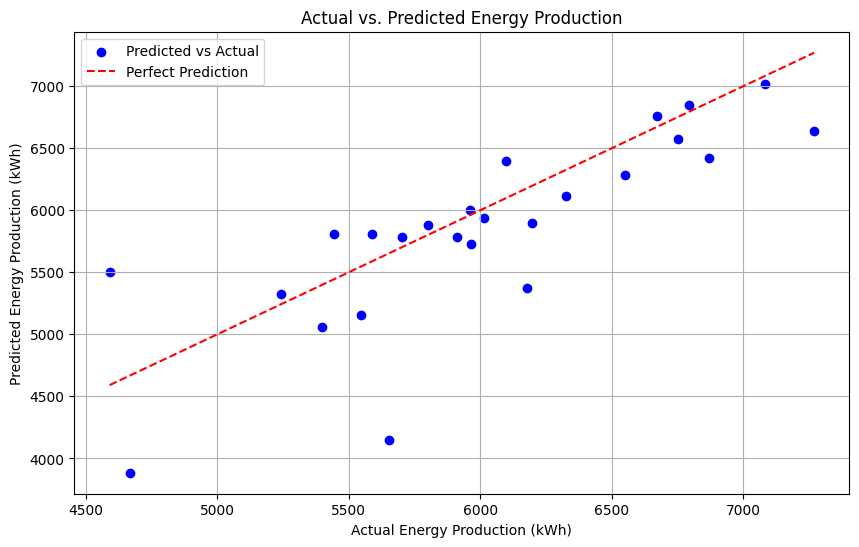

In [37]:
# Train and evaluate multiple models for energy production
models_energy = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'KMeans': KMeans(n_clusters=3, random_state=42),
    'SVM': SVR(),
    'LinearRegression': LinearRegression()
}

for name, model in models_energy.items():
    model.fit(X_train_energy, y_train_energy)
    y_pred_energy = model.predict(X_test_energy)
    mae = mean_absolute_error(y_test_energy, y_pred_energy)
    mse = mean_squared_error(y_test_energy, y_pred_energy)
    r2 = r2_score(y_test_energy, y_pred_energy)
    print(f'Energy Production: {name} - MAE: {mae}, MSE: {mse}, R²: {r2}')


# Plotting the results
plot_actual_vs_predicted(y_test_energy, y_pred_energy)
# plot_residuals(y_test, y_pred)
# plot_feature_importance(model, X)

In [24]:

# Train and evaluate multiple models for ROI
models_roi = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'KMeans': KMeans(n_clusters=3, random_state=42),
    'SVM': SVR(),
    'LinearRegression': LinearRegression()
}

for name, model in models_roi.items():
    model.fit(X_train_roi, y_train_roi)
    y_pred_roi = model.predict(X_test_roi)
    mae = mean_absolute_error(y_test_roi, y_pred_roi)
    mse = mean_squared_error(y_test_roi, y_pred_roi)
    r2 = r2_score(y_test_roi, y_pred_roi)
    print(f'ROI: {name} (ROI) - MAE: {mae}, MSE: {mse}, R²: {r2}')

# Plotting the results
plot_actual_vs_predicted(y_test_roi, y_pred_roi)
# plot_residuals(y_test, y_pred)
# plot_feature_importance(model, X)

RandomForest (Energy Production) - MAE: 355.4726253255206, MSE: 185025.8521534334, R²: -6.1552311783464715
SVM (Energy Production) - MAE: 1929.4694337114743, MSE: 3748710.336199215, R²: -143.96833152763605
LinearRegression (Energy Production) - MAE: 9.094947017729282e-13, MSE: 8.271806125530277e-25, R²: 1.0
RandomForest (ROI) - MAE: 1.5533320833333306, MSE: 3.5434677717803003, R²: -7.564455583172746
KMeans (ROI) - MAE: 21.575959635416666, MSE: 465.93577534726455, R²: -1125.1528281285628
SVM (ROI) - MAE: 7.6408272661617085, MSE: 58.79287143039567, R²: -141.10061115352767
LinearRegression (ROI) - MAE: 3.552713678800501e-15, MSE: 1.262177448353619e-29, R²: 1.0


In [78]:
# prepare data for modeling
X = df[['ghi', 'aqi']]
y = df['energy_production']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


MAE: 353.42607584635397, MSE: 225547.57982258822, R²: -7.722268032084973


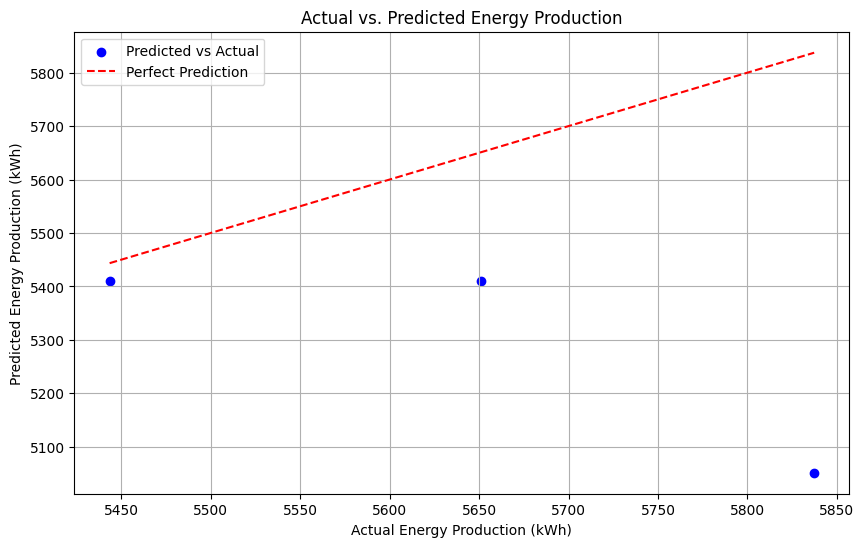

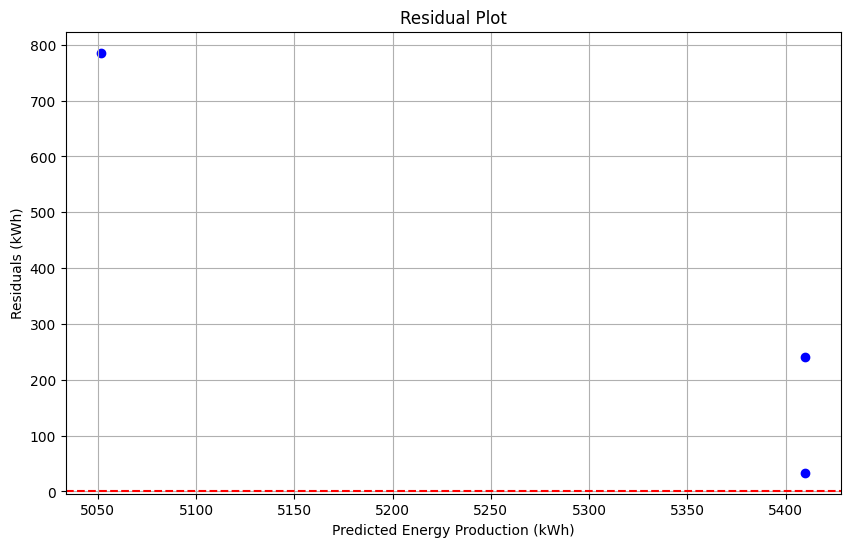

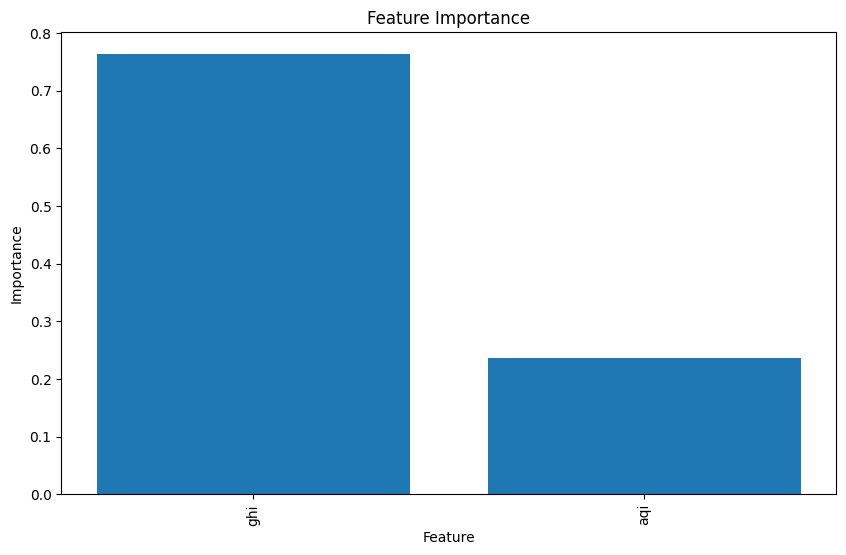

In [79]:
# train and evaluate model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}, MSE: {mse}, R²: {r2}')

# Plotting the results
plot_actual_vs_predicted(y_test, y_pred)
plot_residuals(y_test, y_pred)
plot_feature_importance(model, X)

In [28]:
# prediction for a Trained City and a New City

# Prediction for a trained city (e.g., New York)
new_york = {"city": "New York", "country": "United States", "lat": 40.7128, "lon": -74.0060}
ghi_ny = fetch_solar_irradiance(new_york['lat'], new_york['lon'])
aqi_ny = fetch_air_quality(new_york['lat'], new_york['lon'])
new_data_ny = pd.DataFrame([{"ghi": ghi_ny, "aqi": aqi_ny}])
predicted_energy_ny = model_energy.predict(new_data_ny)
# Assuming we have actual energy production data for New York for comparison
actual_energy_ny = df[df['city'] == 'New York']['energy_production'].values[0]

print(f"Energy production for New York: Predicted={predicted_energy_ny[0]:.2f} kWh,  Actual={actual_energy_ny:.2f} kwh")

# Prediction for a new city (e.g., Amsterdam)
amsterdam = {"city": "Amsterdam", "country": "Netherlands", "lat": 52.3676, "lon": 4.9041}
ghi_ams = fetch_solar_irradiance(amsterdam['lat'], amsterdam['lon'])
aqi_ams = fetch_air_quality(amsterdam['lat'], amsterdam['lon'])
new_data_ams = pd.DataFrame([{"ghi": ghi_ams, "aqi": aqi_ams}])
predicted_energy_ams = model_energy.predict(new_data_ams)
actual_energy_ams = estimate_energy_production("Amsterdam", "Netherlands", 52.3676, 4.9041)

print(f"Energy production for Amsterdam: Predicted={predicted_energy_ams[0]:.2f} kWh, Actual={actual_energy_ams:.2f} kwh")



plot_actual_vs_predicted_new_city(actual_energy_ny, predicted_energy_ny[0], 'New York')

# As we do not have actual energy production data for Amsterdam, we only plot predicted value
plot_actual_vs_predicted_new_city(actual_energy_ams, predicted_energy_ams[0], 'Amsterdam')



NameError: name 'model_energy' is not defined

In [81]:
# debugging cache
import pprint 

try:
    with open(cache_file_path, 'rb') as file:
        data = pickle.load(file)
    print("Loaded cached data.")
except FileNotFoundError:
    print("Cache not found. Please ensure the data has been cached first.")

# Pretty print the cached data
pprint.pprint(data)

Cache not found. Please ensure the data has been cached first.
[{'aqi': 5,
  'city': 'New York',
  'country': 'United States',
  'energy_production': 5443.5595703125,
  'ghi': 1.97,
  'latitude': 40.7128,
  'longitude': -74.006},
 {'aqi': 5,
  'city': 'Los Angeles',
  'country': 'United States',
  'energy_production': 6832.32470703125,
  'ghi': 3.39,
  'latitude': 34.0522,
  'longitude': -118.2437},
 {'aqi': 2,
  'city': 'San Francisco',
  'country': 'United States',
  'energy_production': 6373.32958984375,
  'ghi': 2.47,
  'latitude': 37.7749,
  'longitude': -122.4194},
 {'aqi': 1,
  'city': 'London',
  'country': 'United Kingdom',
  'energy_production': 3714.443115234375,
  'ghi': 0.84,
  'latitude': 51.5074,
  'longitude': -0.1278},
 {'aqi': 5,
  'city': 'Tokyo',
  'country': 'Japan',
  'energy_production': 4667.35546875,
  'ghi': 2.48,
  'latitude': 35.6895,
  'longitude': 139.6917},
 {'aqi': 3,
  'city': 'Sydney',
  'country': 'Australia',
  'energy_production': 2977.650146484375,